In [ ]:
"""
Author: 
Date: 25/12/03
"""

In [4]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
torch.manual_seed(0)

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 9.91M/9.91M [00:16<00:00, 593kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 164kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 592kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.86MB/s]


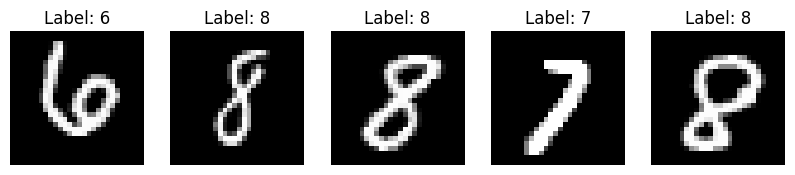

In [6]:
# Get first batch
images, labels = next(iter(train_loader))

# Visualize
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')
plt.show()

In [ ]:
# Build MLP
from re import X


class BasicMLP(nn.Module):
    def __init__(self, hidden_size=100, hidden_size_2=200):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [57]:
model = BasicMLP().to(device)

In [58]:
# Train
def train(train_loader, model, epochs=1):
    total_iterations = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        num_iterations = 0
        loss_sum = 0

        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x.view(-1, 28*28))
            loss = nn.CrossEntropyLoss()(output, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
train(train_loader, model)

Epoch 1: 100%|██████████| 595/595 [00:00<00:00, 642.09it/s, loss=0.0116]


In [59]:
# Get original weights
original_weights = {}
for name, param in model.named_parameters():
    original_weights[name] = param.clone().detach()

In [60]:
# Test
def test(test_loader, model):
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = model(x.view(-1, 28*28))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the digit {i}: {wrong_counts[i]}')

test(test_loader, model)

Testing: 100%|██████████| 1000/1000 [00:00<00:00, 2435.85it/s]

Accuracy: 0.101
wrong counts for the digit 0: 980
wrong counts for the digit 1: 1135
wrong counts for the digit 2: 1032
wrong counts for the digit 3: 1010
wrong counts for the digit 4: 982
wrong counts for the digit 5: 892
wrong counts for the digit 6: 958
wrong counts for the digit 7: 1028
wrong counts for the digit 8: 974
wrong counts for the digit 9: 0


In [61]:
# Get original weights size
total_weights = 0
for index, layer in enumerate([model.fc1, model.fc2, model.fc3]):
    total_weights += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total weights is: {total_weights}')

Layer 1: W: torch.Size([100, 784]) + B: torch.Size([100])
Layer 2: W: torch.Size([200, 100]) + B: torch.Size([200])
Layer 3: W: torch.Size([10, 200]) + B: torch.Size([10])
Total weights is: 100710


In [62]:
# Task: fine-tune w LoRA based on digit 9
# Modify parameters according to LoRA
class LoRAParametrization(nn.Module):
    def __init__(self, features_in, features_out, device, rank=1, alpha=0.01):
        super().__init__()
        # According to the paper, we use a random Gaussian initialization for A and zero for B, so ∆W = BA is zero at the beginning of training
        self.lora_A = nn.Parameter(torch.zeros((rank,features_out)).to(device))
        self.lora_B = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        nn.init.normal_(self.lora_A, mean=0, std=1)
        
        # According to the paper,scale ∆Wx by α/r , where α is a constant in r. My understanding: try keep the similiar "learning_rate" as rank value changed
        # When optimizing with Adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately. 
        # As a result, we simply set α to the first r we try and do not tune it. 
        self.scale = alpha / rank
        self.enabled = True

    def forward(self, original_weights):
        if self.enabled:
            # Return W + (B*A)*scale
            return original_weights + torch.matmul(self.lora_B, self.lora_A).view(original_weights.shape) * self.scale
        else:
            return original_weights


In [63]:
# Add the parameters to the network
# Refer: https://pytorch.org/tutorials/intermediate/parametrizations.html
import torch.nn.utils.parametrize as parametrize

def linear_layer_parameterization(layer, device, rank=1, lora_alpha=1):
    # Only add the parameterization to the weight matrix, ignore the Bias

    # From section 4.2 of the paper:
    #   We limit our study to only adapting the attention weights for downstream tasks and freeze the MLP modules (so they are not trained in downstream tasks) both for simplicity and parameter-efficiency.
    #   [...]
    #   We leave the empirical investigation of [...], and biases to a future work.
    
    features_in, features_out = layer.weight.shape
    return LoRAParametrization(
        features_in, features_out, rank=rank, alpha=lora_alpha, device=device
    )

# Replace fc1 layer's weights to be linear_layer_parameterization's fc1 etc.
parametrize.register_parametrization(
    model.fc1, "weight", linear_layer_parameterization(model.fc1, device)
)
parametrize.register_parametrization(
    model.fc2, "weight", linear_layer_parameterization(model.fc2, device)
)
parametrize.register_parametrization(
    model.fc3, "weight", linear_layer_parameterization(model.fc3, device)
)

ParametrizedLinear(
  in_features=200, out_features=10, bias=True
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): LoRAParametrization()
    )
  )
)

In [64]:
def enable_disable_lora(enabled=True):
    for layer in [model.fc1, model.fc2, model.fc3]:
        layer.parametrizations["weight"][0].enabled = enabled

In [65]:
# Proven that does not alter the original weights but only those introduced by LoRA
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(model.fc1.parametrizations.weight.original == original_weights['fc1.weight'])
assert torch.all(model.fc2.parametrizations.weight.original == original_weights['fc2.weight'])
assert torch.all(model.fc3.parametrizations.weight.original == original_weights['fc3.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(model.fc1.weight, model.fc1.parametrizations.weight.original + (model.fc1.parametrizations.weight[0].lora_B @ model.fc1.parametrizations.weight[0].lora_A) * model.fc1.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(model.fc1.weight, original_weights['fc1.weight'])

In [66]:
# Free non-lora parameters and fine-tune
for name, param in model.named_parameters():
    print(name)
    if 'lora' not in name:
        param.requires_grad = False

# Load the MNIST dataset again, by keeping only the digit 9
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
include_indices = mnist_trainset.targets == 9
mnist_trainset.data = mnist_trainset.data[include_indices]
mnist_trainset.targets = mnist_trainset.targets[include_indices]

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Fine-tuning
train(train_loader, model)


fc1.bias
fc1.parametrizations.weight.original
fc1.parametrizations.weight.0.lora_A
fc1.parametrizations.weight.0.lora_B
fc2.bias
fc2.parametrizations.weight.original
fc2.parametrizations.weight.0.lora_A
fc2.parametrizations.weight.0.lora_B
fc3.bias
fc3.parametrizations.weight.original
fc3.parametrizations.weight.0.lora_A
fc3.parametrizations.weight.0.lora_B


Epoch 1:   0%|          | 0/595 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [67]:
# Test
test(test_loader, model)

Testing: 100%|██████████| 1000/1000 [00:00<00:00, 2411.03it/s]

Accuracy: 0.101
wrong counts for the digit 0: 980
wrong counts for the digit 1: 1135
wrong counts for the digit 2: 1032
wrong counts for the digit 3: 1010
wrong counts for the digit 4: 982
wrong counts for the digit 5: 892
wrong counts for the digit 6: 958
wrong counts for the digit 7: 1028
wrong counts for the digit 8: 974
wrong counts for the digit 9: 0
